## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo IV - Estratégias de Treinamento e Transferência de Aprendizado</span>


### <span style="color:darkred">Avaliação</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

As respostas devem ser dadas no Moodle, use esse notebook apenas para gerar o código necessário para obter as respostas

---


### Questão 1)

Qual a relação entre o modelo chamado de "memorizador" e as redes neurais profundas?

(a) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, tornando-as hábeis para generalizar para dados futuros.<br>
(b) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, falhando em predizer corretamente exemplos não vistos.<br>
(c) Redes neurais com alta capacidade são imunes a convergir para modelos memorizadores, pois obtiveram resultados do estado-da-arte em muitas aplicações.<br>
(d) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, e portanto possuem viés forte.<br>

---

### Questão 2)

O papel do uso conjunto dos métodos BatchNormalization e Regularização é o de:

(a) Pré-processamento dos dados antes da realização do treinamento<br>
(b) Gerar espaço de parâmetros esparsos, com alguns poucos parâmetros com valor alto e muitos com valores próximo a zero, melhorando a generalização<br>
(c) Minimizar o problema do desaparecimento do gradiente, e ao mesmo tempo evitar que poucas unidades/neurônios se especializem demais<br>
(d) Obter robustez com relação à possíveis ataques e propiciar modelos menores com acurácia similar a modelos maiores<br>


---
### Questão 3)

São práticas viáveis para o uso de aprendizado profundo com pequenas bases de dados:

 (a) Carregar uma rede neural profunda popular de um pacote de software e treiná-la a partir de pesos aleatórios<br>
 (b) Carregar uma rede neural profunda pré-treinada em grande base de dados, e utilizar a saída da última camada  da rede, ou seja as predições das classes, como característica para modelos de aprendizado externos que permitem uso com menores bases de dados<br>
 (c) Carregar uma rede neural profunda popular de um pacote de software e treiná-la a partir de pesos aleatórios utilizando Batch Normalization<br>
 (d) Carregar uma rede neural profunda pré-treinada em grande base de dados, inserindo uma nova camada de saída treinando apenas essa camada com a pequena base de dados<br>

---

### Questão 4)

Carregue a base de dados Fashion MNIST conforme código abaixo e crie um modelo de CNN com a seguinte arquitetura, capaz de obter classificação nessa base de dados de imagens. Considere que todas as camadas convolucionais tem zeropadding, e ativação relu, exceto quando mencionado contrário.

1. Pré-processamento para aumentação contendo:
  * RandomZoom(0.1),
  * RandomContrast(0.2)
1. Convolucional 2D com 64 filtros $3\times 3$.
2. Batch Normalization
3. SeparableConv2D com 64 filtros $3\times 3$.
4. MaxPooling2D $3\times 3$ e strides $2$
5. Batch Normalization
6. SeparableConv2D com 256 filtros $3\times 3$.
7. MaxPooling2D $3\times 3$ e strides $2$
8. GlobalAveragePooling
9. Dropout de 0.2
10. Densa com ativação softmax

Incialize as sementes do numpy com 1 e tensorflow com 2 e treine o modelo por 7 épocas com batch size 16, otimizador Adam e taxa de aprendizado 0.002.

Após o treinamento utilize a função predict para classificar imagens da posicao 10 a 14 no conjunto de testes (\[10:15\]). Quais as classes resultantes e quantas dessas estavam erradas?

(a) 2, 5, 5, 3, 3, sendo 2 erradas<br>
(b) 4, 5, 5, 3, 4, sendo 2 erradas<br>
(c) 4, 5, 5, 3, 4 sendo 1 errada<br>
(d) 4, 5, 5, 3, 4, nenhuma errada<br>

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

img_lin, img_col = train_images.shape[1], train_images.shape[2]
num_classes = len(np.unique(train_labels))
print(train_images.shape)
print('Classes: ', num_classes)

train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

# quantidade de canais
if (len(train_images.shape) == 3):
      n_channels = 1
else:
      n_channels = train_images.shape[3]

if keras.backend.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], n_channels, img_lin, img_col)
    test_images = test_images.reshape(test_images.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    train_images = train_images.reshape(train_images.shape[0], img_lin, img_col, n_channels)
    test_images = test_images.reshape(test_images.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

(60000, 28, 28)
Classes:  10


In [50]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(0.2),
    ]
)

In [51]:
def my_cnn(input_shape, num_classes):
    """
    1. Convolucional 2D com 64 filtros 3 x 3.
    2. Batch Normalization
    3. SeparableConv2D com 64 filtros 3 x 3.
    4. MaxPooling2D 3 x 3 e strides 2
    5. Batch Normalization
    6. SeparableConv2D com 256 filtros 3 x 3.
    7. MaxPooling2D 3 x 3 e strides 2
    8. GlobalAveragePooling
    9. Dropout de 0.2
    10. Densa com ativação softmax

    """

    inputs = keras.Input(shape=input_shape)
    
    # Pré-processamento
    x = data_augmentation(inputs)

    # 1. Convolucional 2D com 64 filtros 3 x 3.
    x = layers.Conv2D(64, 3, padding="same")(x)
    
    # 2. Batch Normalization
    x = layers.BatchNormalization()(x)

    # ATIVAÇÃO RELU
    x = layers.Activation("relu")(x)

    # 3. SeparableConv2D com 64 filtros 3 x 3.
    x = layers.SeparableConv2D(64, 3, padding="same")(x)

    # 4. MaxPooling2D 3 x 3 e strides 2
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    # 5. Batch Normalization
    x = layers.BatchNormalization()(x)

    # ATIVAÇÃO RELU
    x = layers.Activation("relu")(x)

    # 6. SeparableConv2D com 256 filtros 3 x 3.
    x = layers.SeparableConv2D(256, 3, padding="same")(x)

    # 7. MaxPooling2D 3 x 3 e strides 2
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # ATIVAÇÃO RELU
    x = layers.Activation("relu")(x)

    # 8. GlobalAveragePooling
    x = layers.GlobalAveragePooling2D()(x)

    # ATIVAÇÃO RELU
    x = layers.Activation("relu")(x)

    # 9. Dropout de 0.2
    x = layers.Dropout(0.2)(x)
    
    # 10. Densa com ativação softmax
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [52]:
seed(1) #Numpy
set_seed(2) #Tensorflow
epochs = 7
model = my_cnn(input_shape, num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.002),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)       

In [53]:
hist = model.fit(train_images, train_labels, batch_size=16,
                    epochs=epochs, verbose=1)

Epoch 1/7
3750/3750 [==============================] - 29s 8ms/step - loss: 0.6416 - accuracy: 0.7644
Epoch 2/7
3750/3750 [==============================] - 28s 8ms/step - loss: 0.4137 - accuracy: 0.8516
Epoch 3/7
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3630 - accuracy: 0.8696
Epoch 4/7
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3351 - accuracy: 0.8792
Epoch 5/7
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3175 - accuracy: 0.8860
Epoch 6/7
3750/3750 [==============================] - 28s 8ms/step - loss: 0.3029 - accuracy: 0.8899
Epoch 7/7
3750/3750 [==============================] - 28s 8ms/step - loss: 0.2925 - accuracy: 0.8940


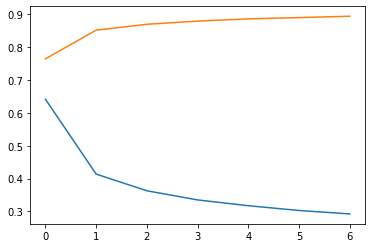

In [54]:
plt.plot(hist.history['loss']);
plt.plot(hist.history['accuracy']);

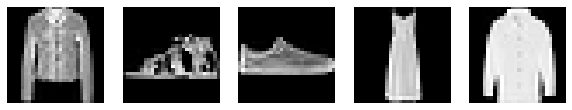

In [35]:
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

fig, axes = plt.subplots(1,5, figsize=(10,2))
ax = axes.ravel()
for i in range(5):
    ax[i].imshow(predizer[i], cmap="gray")
    # ax[i].title(str(test_labels[i]))
    ax[i].axis('off')


In [39]:
# Lista de Valores Possíveis
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [29]:
# Valores corretos
test_labels[10:15]

array([4, 5, 7, 3, 4], dtype=uint8)

In [32]:
# cria a variável com as imagens a serem preditas
predizer = test_images[10:15]

In [55]:
# Faz a predição
resultado = model.predict(predizer)

In [41]:
# Resultados da primeira versão do modelo
for i in range(5):
    print(f'Imagem {i}: {resultado[i]}')

Imagem 0: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Imagem 1: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Imagem 2: [0.         0.         0.         0.         0.         0.56184226
 0.         0.         0.4381578  0.        ]
Imagem 3: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Imagem 4: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
Imagem 1: 4
Imagem 2: 5
Imagem 3: 5 ou 8
Imagem 4: 4
Imagem 5: 4

In [56]:
# Resultados da segunda versão do Modelo
for i in range(5):
    print(f'Imagem {i}: {resultado[i]}')

Imagem 0: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Imagem 1: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Imagem 2: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Imagem 3: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Imagem 4: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


---

### Questão 5)

Carregue a base de dados MNIST do pacote Keras, e pre-processe conforme código abaixo.

Vamos utilizar o modelo treinado na questão anterior como forma de trasnferência de aprendizado. Se preciso reinicialize o modelo e treine-o novamente para garantir que apenas 7 épocas foram executadas. O modelo final deve ter acurácia de treinamento próxima a 0.89 (computada na base Fashion). 

Agora, assuma que esse modelo já treinado está armazenado numa variável `model`. Então proceda da seguinte forma:

1. Obtendo a saída da penúltima camada (referente ao Dropout):

`base_saida = model.layers[-2].output`

2. Criando uma nova camada de saída que recebe como entrada a anterior 

`saida_nova = keras.layers.Dense(10, activation='softmax')(base_saida)`

3. Criando um novo modelo tendo essa nova camada como saída 

`model2 = keras.models.Model(model.inputs, saida_nova)`

Você pode usar o summary para conferir o modelo montado.

Agora inicialize as sementes do numpy para 1 e tensorflow para 2, compile e treine o novo modelo com função de custo entropia cruzada categórica, otimizador Adam com taxa de aprendizado 0.002, 16 exemplos no mini-batch e 3 épocas.

Avalie a acurácia no conjunto de testes. Em qual intervalo está a acurácia resultante, considerando arredondamento para 2 casas decimais?

(a) [0.94,0.96]<br>
(b) [0.98,1.00]<br>
(c) [0.87,0.90]<br>
(d) [0.92,0.93]<br>

In [5]:
mnist = keras.datasets.mnist
(train_images2, train_labels2), (test_images2, test_labels2) = mnist.load_data()
train_images2 = train_images2 / 255.0
test_images2 = test_images2 / 255.0
train_labels2 = keras.utils.to_categorical(train_labels2, 10)
test_labels2 = keras.utils.to_categorical(test_labels2, 10)